In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import functools
from sklearn import datasets
import matplotlib.pyplot as plt
from torch.optim import Adam
from torch.optim import SGD
from torch.utils.data import DataLoader
from tqdm import notebook
import seaborn as sns
import math
import scipy
import pandas as pd
from IPython.display import Image
from torch.distributions import MultivariateNormal

#import models
from models import ScoreNet_BOD, cde_ScoreNet_BOD

#import training fns
from training import loss_fn, train_model, CDE_loss_fn_BOD

#import SDE functions
from SDE import marginal_prob_std_fn_BOD as marginal_prob_std_fn
from SDE import diffusion_coeff_fn_BOD as diffusion_coeff_fn

#import sampling fns
from sampling import pc_sampler_BOD as pc_sampler
from sampling import Euler_Maruyama_sampler_BOD as Euler_Maruyama_sampler
from sampling import CDiffE_Euler_Maruyama_sampler_BOD as CDiffE_Euler_Maruyama_sampler
from sampling import CDiffE_pc_sampler_BOD as CDiffE_pc_sampler
from sampling import CDE_pc_sampler_BOD as CDE_pc_sampler
from sampling import SMCDiff_pc_sampler_BOD as SMCDiff_pc_sampler

# Generate training dataset

In [2]:
data = torch.load('data/BOD.pt')

# Train unconditional model

In [5]:
score_model = ScoreNet_BOD(marginal_prob_std=marginal_prob_std_fn)

In [4]:
losses = train_model(score_model, data, loss_fn, marginal_prob_std_fn, 'import_test.pth', epochs = 10, batch_size = 10000)

  0%|          | 0/10 [00:00<?, ?it/s]

/Users/harryamad/Google Drive/2022/Dissertation/conditional_diffusion_simulation/SDE.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t)


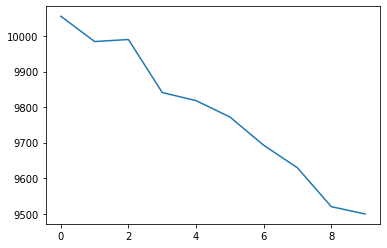

In [5]:
plt.plot(losses)

# Draw unconditional samples

In [5]:
def density_plot(sample):
    df = pd.DataFrame(sample.numpy())
    df.columns =['x1', 'x2', 'y1', 'y2', 'y3', 'y4', 'y5']
    sns.displot(df, x ='x1', y='x2', kind="kde")

In [7]:
ckpt = torch.load('models/BOD.pth')
score_model.load_state_dict(ckpt)

<All keys matched successfully>

In [8]:
pc_samples = pc_sampler(score_model, marginal_prob_std_fn, diffusion_coeff_fn, batch_size = 1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/harryamad/Google Drive/2022/Dissertation/conditional_diffusion_simulation/SDE.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t)


In [9]:
e_m_samples = Euler_Maruyama_sampler(score_model, marginal_prob_std_fn, diffusion_coeff_fn, batch_size=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [10]:
torch.mean(pc_samples, axis=0)

tensor([-0.0488, -0.0109,  0.1178,  0.2098,  0.2962,  0.3518,  0.3927])

In [11]:
torch.mean(data, axis=0)

tensor([0.0063, 0.0037, 0.1164, 0.2113, 0.2894, 0.3541, 0.4075])

In [12]:
torch.var(pc_samples, axis=0)

tensor([0.8971, 1.0288, 0.0068, 0.0158, 0.0269, 0.0378, 0.0446])

In [13]:
torch.var(data, axis=0)

tensor([1.0015, 1.0007, 0.0059, 0.0160, 0.0270, 0.0371, 0.0455])

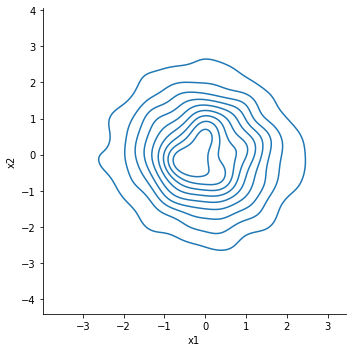

In [14]:
density_plot(pc_samples)

In [15]:
torch.mean(e_m_samples, axis=0)

tensor([-0.0509, -0.0466,  0.1159,  0.2062,  0.2890,  0.3512,  0.3922])

In [16]:
torch.mean(data, axis=0)

tensor([0.0063, 0.0037, 0.1164, 0.2113, 0.2894, 0.3541, 0.4075])

In [17]:
torch.var(e_m_samples, axis=0)

tensor([0.9782, 1.0546, 0.0069, 0.0173, 0.0287, 0.0399, 0.0485])

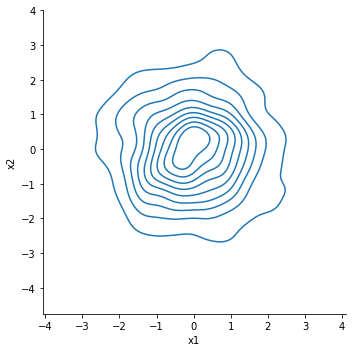

In [18]:
gen_data = pd.DataFrame(e_m_samples.numpy())
gen_data.columns =['x1', 'x2', 'y1', 'y2', 'y3', 'y4', 'y5']
sns.displot(gen_data, x ='x1', y='x2', kind="kde")

<hr style="border:2px solid black">

# CDiffE replacement method

## Draw CDiffE samples

In [2]:
y_obs = torch.tensor([0.18, 0.32, 0.42, 0.49, 0.54])

In [10]:
score_model = ScoreNet_BOD(marginal_prob_std=marginal_prob_std_fn)
ckpt = torch.load('models/BOD.pth')
score_model.load_state_dict(ckpt)
cdiffe_samples = CDiffE_pc_sampler(score_model, 
                           marginal_prob_std_fn,
                           diffusion_coeff_fn, 
                           y_obs = y_obs, batch_size = 1000, eps = 1e-5)

/Users/harryamad/Google Drive/2022/Dissertation/conditional_diffusion_simulation/SDE.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t)


  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/harryamad/Google Drive/2022/Dissertation/conditional_diffusion_simulation/SDE.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t)


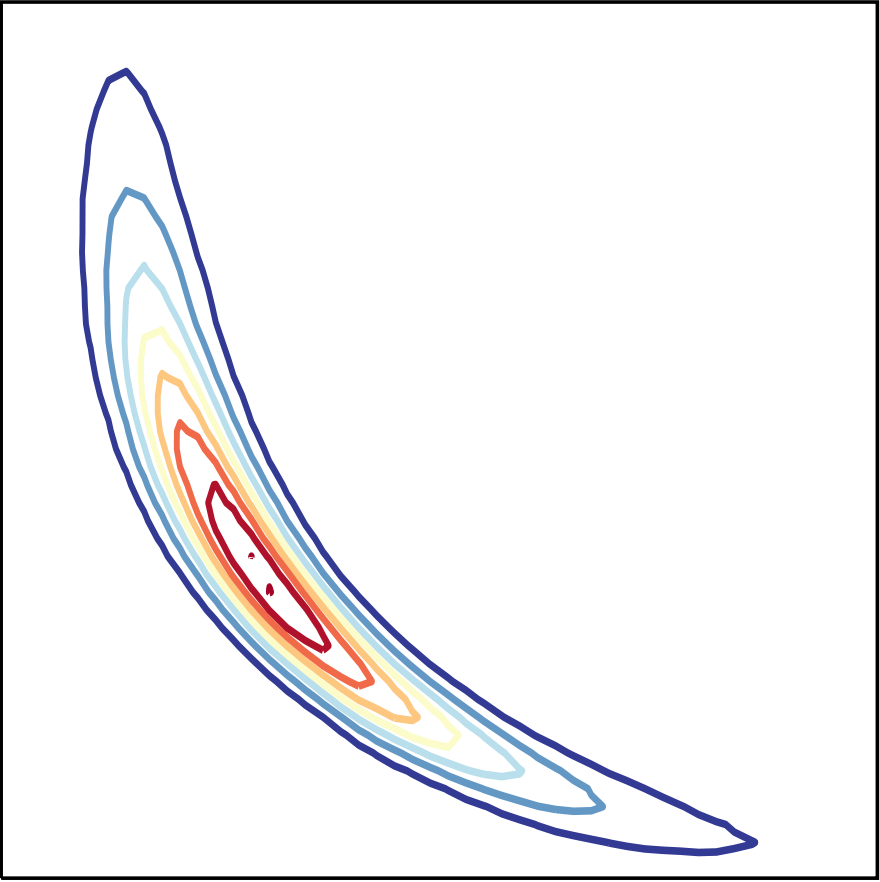

In [21]:
Image("plots/BOD target density.png", width=300, height=300)

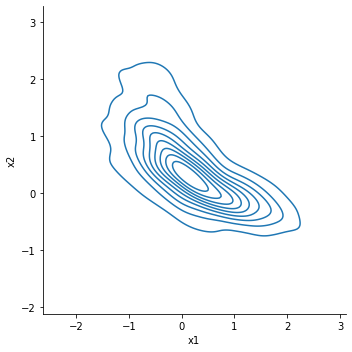

In [11]:
density_plot(cdiffe_samples)

In [9]:
torch.mean(cdiffe_samples, axis=0)

tensor([0.1839, 0.3427, 0.1635, 0.3006, 0.4467, 0.4814, 0.5297])

In [13]:
torch.var(cdiffe_samples[:, [0,1]], axis=0)

tensor([0.6097, 0.4480])

In [11]:
scipy.stats.skew(cdiffe_samples[:, [0,1]])

array([0.41351473, 0.73690856], dtype=float32)

In [12]:
scipy.stats.kurtosis(cdiffe_samples[:, [0,1]])

array([0.25706673, 0.4525783 ], dtype=float32)

<hr style="border:2px solid black">

# CDE tailored conditional method

## Train conditioned model

In [3]:
score_model = cde_ScoreNet_BOD(marginal_prob_std=marginal_prob_std_fn)
losses = train_model(score_model, data, CDE_loss_fn_BOD, marginal_prob_std_fn, 'import_test.pth', epochs = 100, batch_size = 1000)

  0%|          | 0/100 [00:00<?, ?it/s]

/Users/harryamad/Google Drive/2022/Dissertation/conditional_diffusion_simulation/SDE.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t)


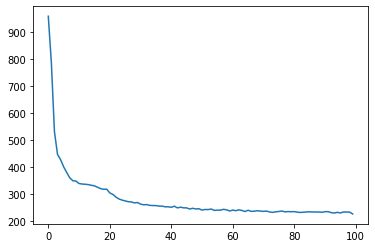

In [30]:
plt.plot(losses)

## Draw CDE samples

In [8]:
score_model = cde_ScoreNet_BOD(marginal_prob_std=marginal_prob_std_fn)
ckpt = torch.load('models/cde_BOD.pth')
score_model.load_state_dict(ckpt)
cde_samples = CDE_pc_sampler(score_model, 
                           marginal_prob_std_fn,
                           diffusion_coeff_fn, 
                           y_obs = y_obs, batch_size = 1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

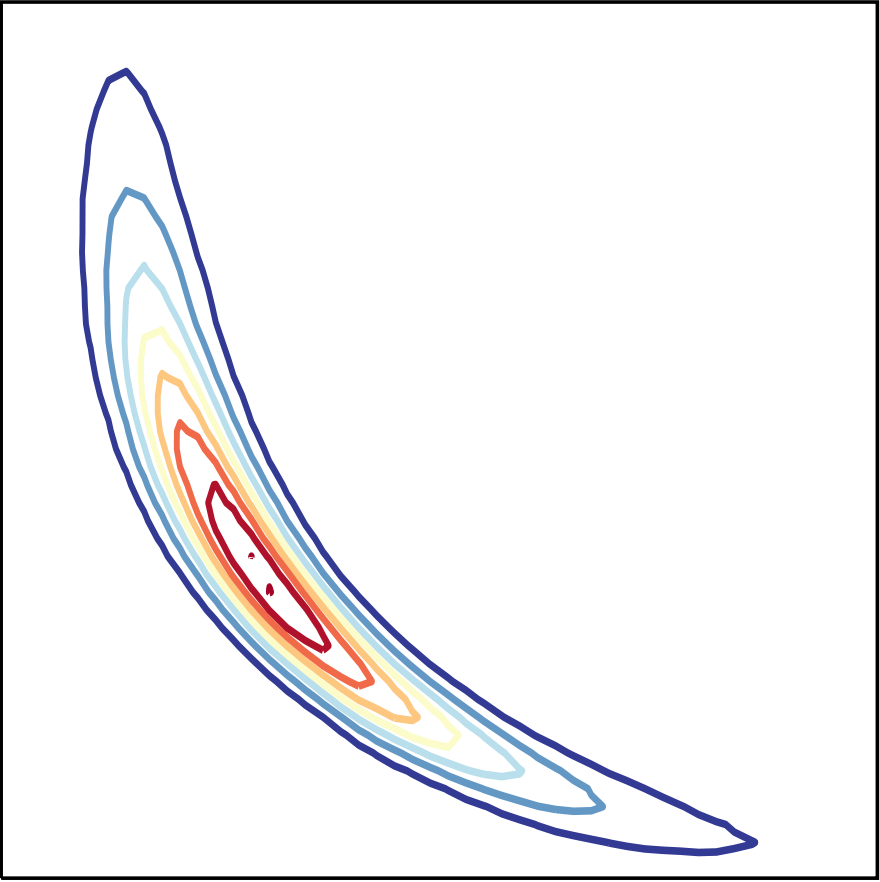

In [38]:
Image("plots/BOD target density.png", width=300, height=300)
#make my own version with scale? would need to generate MCMC points

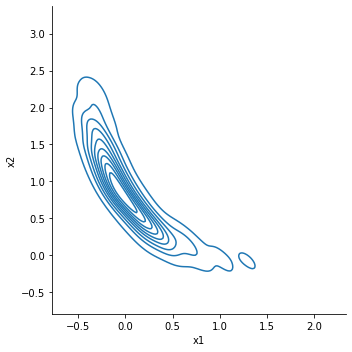

In [9]:
density_plot(cde_samples)

In [7]:
torch.mean(cde_samples, axis=0)

tensor([0.0598, 0.8560, 0.1800, 0.3200, 0.4200, 0.4900, 0.5400])

In [8]:
torch.var(cde_samples[:,[0,1]], axis=0)

tensor([0.1237, 0.3402])

In [9]:
scipy.stats.skew(cde_samples[:,[0,1]])

array([1.3318522 , 0.68175125], dtype=float32)

In [10]:
scipy.stats.kurtosis(cde_samples[:,[0,1]])

array([2.391852  , 0.36459494], dtype=float32)

<hr style="border:2px solid black">

# SMCDiff method

## Draw SMCDiff samples

In [12]:
score_model = ScoreNet_BOD(marginal_prob_std=marginal_prob_std_fn)
ckpt = torch.load('models/BOD.pth')
score_model.load_state_dict(ckpt)

smcdiff_samples = SMCDiff_pc_sampler(score_model, 
                           marginal_prob_std_fn,
                           diffusion_coeff_fn, 
                           y_obs = y_obs, k = 1000)

smc_df = pd.DataFrame(smcdiff_samples.numpy())
smc_df.columns =['x1', 'x2', 'y1', 'y2', 'y3', 'y4', 'y5']

/Users/harryamad/Google Drive/2022/Dissertation/conditional_diffusion_simulation/SDE.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t)


  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/harryamad/Google Drive/2022/Dissertation/conditional_diffusion_simulation/SDE.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t)


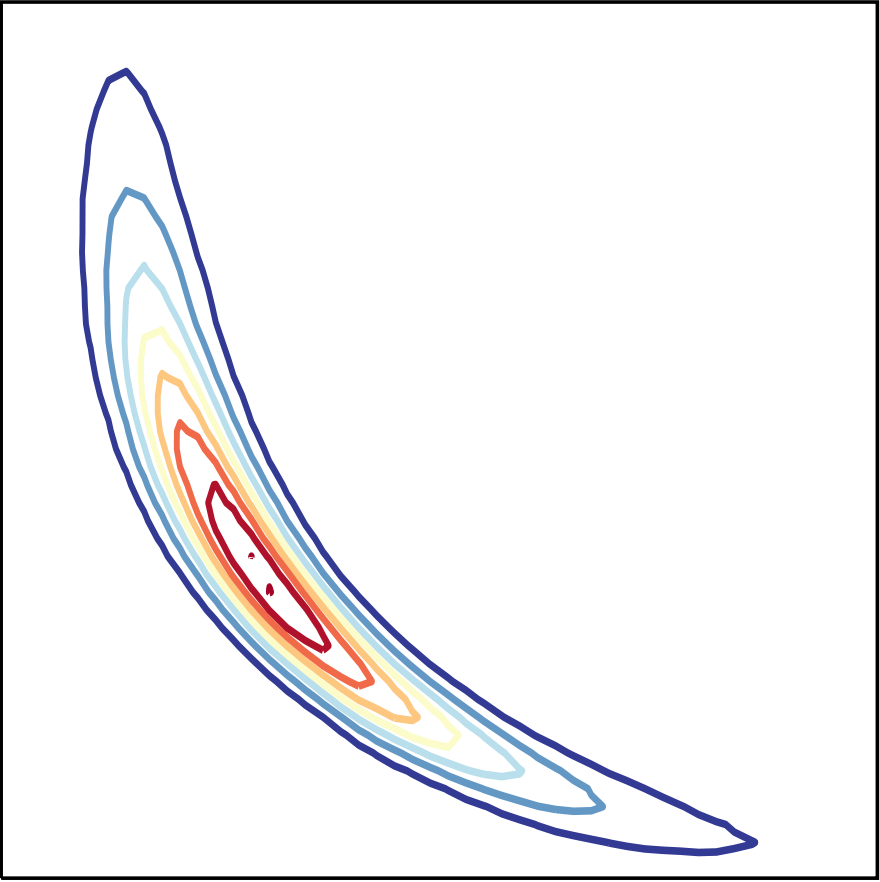

In [7]:
Image("plots/BOD target density.png", width=300, height=300)
#make my own version with scale? would need to generate MCMC points

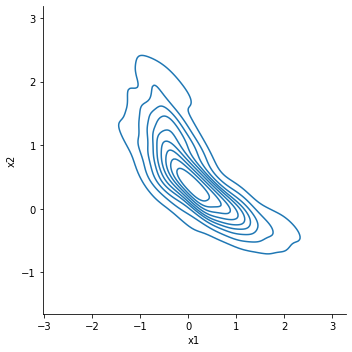

In [13]:
sns.displot(smc_df, x ='x1', y='x2', kind="kde")

In [11]:
torch.mean(smcdiff_samples, axis=0)

tensor([0.1458, 0.4590, 0.1524, 0.2997, 0.4437, 0.5037, 0.5807])

In [304]:
torch.var(smcdiff_samples[:,[0,1]], axis=0)

tensor([0.4648, 0.3879])

In [305]:
scipy.stats.skew(smcdiff_samples[:,[0,1]])

array([0.719118  , 0.79025537], dtype=float32)

In [306]:
scipy.stats.kurtosis(smcdiff_samples[:,[0,1]])

array([0.9850652, 0.6490288], dtype=float32)

<hr style="border:2px solid black">

# Comparison

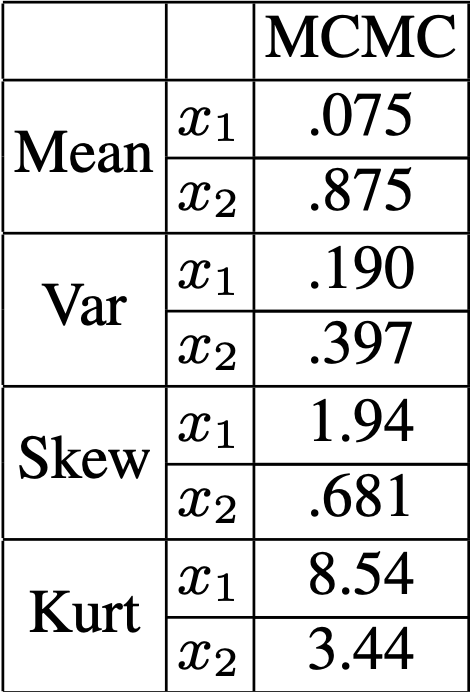

In [14]:
Image("plots/BOD target stats.png", width=300, height=300)

In [15]:
cdiffe_mean = torch.mean(cdiffe_samples[:, [0,1]], axis=0).reshape(2,1)
cde_mean = torch.mean(cde_samples[:, [0,1]], axis=0).reshape(2,1)
smc_mean = torch.mean(smcdiff_samples[:, [0,1]], axis=0).reshape(2,1)

means = torch.hstack([cdiffe_mean, cde_mean, smc_mean])
means

tensor([[0.1588, 0.0368, 0.0916],
        [0.4002, 0.8845, 0.5316]])

In [16]:
cdiffe_var = torch.var(cdiffe_samples[:, [0,1]], axis=0).reshape(2,1)
cde_var = torch.var(cde_samples[:, [0,1]], axis=0).reshape(2,1)
smc_var = torch.var(smcdiff_samples[:, [0,1]], axis=0).reshape(2,1)

var = torch.hstack([cdiffe_var, cde_var, smc_var])
var

tensor([[0.4961, 0.1164, 0.4657],
        [0.3190, 0.2860, 0.3568]])

In [17]:
cdiffe_skew = scipy.stats.skew(cdiffe_samples[:, [0,1]], axis=0)
cde_skew = scipy.stats.skew(cde_samples[:, [0,1]], axis=0)
smc_skew = scipy.stats.skew(smcdiff_samples[:, [0,1]], axis=0)

skew = np.stack([cdiffe_skew, cde_skew, smc_skew])
skew.T

array([[0.23782197, 1.9579612 , 0.5790358 ],
       [0.9020945 , 0.48040077, 0.6738305 ]], dtype=float32)

In [18]:
cdiffe_kurt = scipy.stats.kurtosis(cdiffe_samples[:, [0,1]], axis=0)
cde_kurt = scipy.stats.kurtosis(cde_samples[:, [0,1]], axis=0)
smc_kurt = scipy.stats.kurtosis(smcdiff_samples[:, [0,1]], axis=0)

kurt = np.stack([cdiffe_kurt, cde_kurt, smc_kurt])
kurt.T

array([[0.07968807, 5.939357  , 0.5340557 ],
       [1.0887613 , 0.08717942, 0.20253849]], dtype=float32)